# 1) Looking for and 2) Removing empty and small ROIs

**FIRST PART**:  
The *'ROI_values_count_ALL_FILES'* CSV file is used in this notebook. This file contains the count of values in each ROI (i.e., each file). Additional columns are derived from splitting the filename (class, sim, plane, and event). The filename, which is used as the index, has the *.extracted* extension. The filenames to be removed are determined based on the filtering and grouping of the CSV file.The results are saved as dictionaries in JSON format.
    
**SECOND PART**:  
The JSON files are used to remove unnecessary files.
The process relies on a function that accepts a dictionary with keys 'ATMO' and 'PDK', where the items are lists of files to be removed (one per event). An example structure is as follows: **events_to_remove_dict = {'ATMO': ['filename.extracted'], 'PDK': []}**.

The dictionary contains one file per event, but all three planes associated with the event are removed and moved to the *REMOVED_npz folder*. Each time the function is called, a new subdirectory can be created within REMOVED_npz by providing a chosen name (*subdir*) to the function. Within this subdirectory, two additional folders are created: ATMO and PDK. There is no further subdivision by plane.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import os
import shutil
import json

## First part

In [2]:
df = pd.read_csv('ROI_values_count_ALL_FILES.csv')
df.set_index('filename', inplace=True)

### Looking for the empty ROIs

In [ ]:
# The code filters and groups the DataFrame to identify files with empty regions of interest (ROI).
# It then categorizes these filenames into two groups: AtmoNu and PDK.
# Finally, it saves the categorized filenames in a dictionary and writes the dictionary to a JSON file.

In [3]:
# Filter the DataFrame for rows where 'ROI_values_count' is 0 (i.e., empty ROIs)
empty_roi_df = df[df['ROI_values_count'] == 0]
#print(empty_roi_df.head())

# Group the filtered df by 'atmonu_or_pdk', 'MC_sim', and 'event'
# Aggregate by counting the number of 'plane' per group and collecting the index (filenames)
empty_roi_gby = (empty_roi_df.groupby(['atmonu_or_pdk', 'MC_sim', 'event']).agg(nr_planes=('plane', 'size'),
         filename_list=('plane', lambda x: list(x.index))).reset_index())
#print(empty_roi_gby.head())

# Flatten the list of filenames from the grouped df
empty_roi_filename_list = [file for sublist in empty_roi_gby['filename_list'] for file in sublist]
# Filter the filenames that contain 'AtmoNu' and 'PDK'
atmonu_files = [file for file in empty_roi_filename_list if 'AtmoNu' in file]
pdk_files = [file for file in empty_roi_filename_list if 'PDK' in file]
# Create a dictionary with the filenames categorized by 'ATMO' and 'PDK'
empty_roi_filename_dict = { 'ATMO' : atmonu_files, 'PDK': pdk_files}
#print(empty_roi_filename_dict)

# Print the count of empty AtmoNu and PDK files
print(f"{len(empty_roi_filename_dict['ATMO'])} AtmoNu files are empty")
print(f"{len(empty_roi_filename_dict['PDK'])} PDK files are empty")

# Save the dictionary to a JSON file
with open('empty_roi_filename_dictionary.json', 'w') as file:
    json.dump(empty_roi_filename_dict, file)
print('empty_roi_filename_dictionary.json saved')

16 AtmoNu files are empty
6 PDK files are empty
empty_roi_filename_dictionary.json saved


### Looking for the ROIs with few values

In [ ]:
# Filtering Small ROIs: The code filters the df to only include events where the ROI_values_count is greater than 0 and less than a specified threshold (100).
# This excludes empty regions and focuses on small ROIs.
# Grouping and Aggregation: The filtered data is grouped by specific columns (atmonu_or_pdk, MC_sim, and event),
# and the number of planes (nr_planes) and the list of filenames (filename_list) are aggregated for each group.
# Visualization: A bar plot is created to show how many events have 1, 2, or 3 planes with small ROIs.

# Dictionary Creation and JSON Export:
# Two dictionaries are created:
# All planes: Includes all filenames for events with small ROIs.
# One plane: Includes only one plane from each event.
# These dictionaries are categorized by 'ATMO' and 'PDK', based on whether the filename contains 'AtmoNu' or 'PDK'.
# File Output: Both dictionaries are saved to JSON files.

In [4]:
# Set a threshold for small ROIs
threshold = 100

# Filter the df to include only rows where the 'ROI_values_count' is between 0 and the threshold
small_roi_df = df[(df['ROI_values_count'] > 0) & (df['ROI_values_count'] < threshold)] # Empty ROIs are excluded
#print(small_roi_df.head())

# Group the filtered df by 'atmonu_or_pdk', 'MC_sim', and 'event'
# Count the number of planes in each group and collect their filenames (index)
small_roi_gby = (small_roi_df.groupby(['atmonu_or_pdk', 'MC_sim', 'event']).agg(nr_planes=('plane', 'size'),
         filename_list=('plane', lambda x: list(x.index))).reset_index())
#print(small_roi_gby.head())

nr_planes
1    280
2     52
3      7
Name: count, dtype: int64


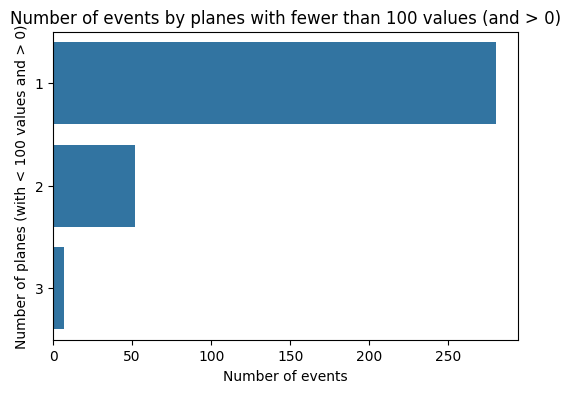

In [6]:
# Count how many events have 1, 2, or 3 planes with small ROIs (less than the threshold)
count = small_roi_gby['nr_planes'].value_counts()
print(count)

# Plot the distribution of events by the number of planes with small ROIs
plt.figure(figsize=(6, 4))
sns.barplot(x=count, y=['1', '2', '3'])
plt.title(f'Number of events by planes with fewer than {threshold} values (and > 0)')
plt.xlabel('Number of events')
plt.ylabel(f'Number of planes (with < {threshold} values and > 0)')
plt.show()

In [ ]:
# Plot description:
# 280 events have only one plane with less than 100 values,
# 52 events have two planes with less than 100 values,
# 7 events have all three planes with less than 100 values.

In [ ]:
#print(small_roi_gby[small_roi_gby['nr_planes'] == 3])   # Filters and displays events with all three planes below threshold

In [ ]:
small_roi_gby['filename_list']

# ALL FILES
# Dictionary containing all small ROI files (across all planes)
small_roi_all_planes_filename_list = [file for sublist in small_roi_gby['filename_list'] for file in sublist]

# Separate the files into 'AtmoNu' and 'PDK' based on their names
atmonu_files = [file for file in small_roi_all_planes_filename_list if 'AtmoNu' in file]
pdk_files = [file for file in small_roi_all_planes_filename_list if 'PDK' in file]

# Create a dictionary that categorizes small ROI files by 'ATMO' and 'PDK'
small_roi_all_planes_filename_dict = { 'ATMO' : atmonu_files, 'PDK': pdk_files}
#print(small_roi_all_planes_filename_dict)

# Save the dictionary of small ROI files (all planes) to a JSON file
with open('small_roi_all_planes_filename_dictionary.json', 'w') as file:
    json.dump(small_roi_all_planes_filename_dict, file)
print('small_roi_all_planes_filename_dictionary.json saved')

# ONE FILE PER EVENT
# Create a dictionary for one small ROI file per event (taking only the first plane)
small_roi_one_plane_filename_list = [sublist[0] for sublist in small_roi_gby['filename_list']]

# Again, separate the 'AtmoNu' and 'PDK' files
atmonu_files = [file for file in small_roi_one_plane_filename_list if 'AtmoNu' in file]
pdk_files = [file for file in small_roi_one_plane_filename_list if 'PDK' in file]

# Create a dictionary that categorizes these single-plane small ROI files by 'ATMO' and 'PDK'
small_roi_one_plane_filename_dict = { 'ATMO' : atmonu_files, 'PDK': pdk_files}
#print(small_roi_one_plane_filename_dict)

# Save the dictionary of single small ROI files to a JSON file
with open('small_roi_one_plane_filename_dictionary.json', 'w') as file:
    json.dump(small_roi_one_plane_filename_dict, file)
print('small_roi_one_plane_filename_dictionary.json saved')

## Second part

### Removing some npz files

In [ ]:
# Define the directory where all .npz files are stored
npz_dir = 'path/to/npz'

# Create lists of directories for each class (0 = ATMO, 1 = PDK) across 3 planes (0, 1, 2)
class_0_dirs = [f"{npz_dir}/{plane}/ATMO" for plane in range(3)]
class_1_dirs = [f"{npz_dir}/{plane}/PDK" for plane in range(3)]

class_dirs = [class_0_dirs, class_1_dirs]

In [ ]:
"""
moving_files function:
This function takes a dictionary of filenames and a subdirectory name as input.
It loops over the directories for each class (ATMO and PDK), 
checks for matches between the filenames in the directory and the filenames in the dictionary (stripped of the .npz extension),
and moves those files to a new subdirectory under REMOVED_npz.
"""
def moving_files(filename_dict, subdir):
    # Iterate over each class directory (ATMO and PDK)
    for class_dir in class_dirs:
        # Extract the class name (either 'ATMO' or 'PDK') from the directory path
        atmo_pdk = class_dir[0].strip().split('/')[-1]
        # Define the destination directory for the moved files (create it if it doesn't exist)
        destination_dir = f'REMOVED_npz/{subdir}/{atmo_pdk}'
        os.makedirs(destination_dir, exist_ok=True)
        for f0, f1, f2 in tqdm.tqdm(zip(
            sorted(os.listdir(class_dir[0])),  # List of files in plane 0
            sorted(os.listdir(class_dir[1])),  # List of files in plane 1
            sorted(os.listdir(class_dir[2]))   # List of files in plane 2
            )):
            # Iterate over all files from the dictionary for the current class (ATMO or PDK)
            for file in sorted(filename_dict[atmo_pdk]):
                # file is .extracted; f0, f1, f2 are .extracted.npz
                if (file == f0.rstrip('.npz')) or (file == f1.rstrip('.npz')) or (file == f2.rstrip('.npz')):
                    # Construct the source paths for files from all three planes
                    f0_path = f'{class_dir[0]}/{f0}'
                    f1_path = f'{class_dir[1]}/{f1}'
                    f2_path = f'{class_dir[2]}/{f2}'
                    # Construct the destination paths for the files
                    destination_path0 = f"{destination_dir}/{f0}"         
                    destination_path1 = f"{destination_dir}/{f1}"
                    destination_path2 = f"{destination_dir}/{f2}"
                    # Move the files from the source directories to the destination directories
                    shutil.move(f0_path, destination_path0)
                    shutil.move(f1_path, destination_path1)
                    shutil.move(f2_path, destination_path2)
                    filename_dict[atmo_pdk].remove(file)
                            
        print(f'Files moved to REMOVED_npz/{subdir}/{atmo_pdk}')

In [ ]:
# Moving the empty ROI files

# Load the dictionary containing the list of empty ROI files
with open('empty_roi_filename_dictionary.json', 'r') as file:
    empty_roi_filename_dict = json.load(file)
    
# Call the function to move the empty files to a designated subdirectory. Subdir is the name of the new folder in REMOVED_npz
moving_files(filename_dict = empty_roi_filename_dict, subdir = 'empty')

In [ ]:
# Moving the small ROI files

# Load the dictionary containing the list of small ROI files (one per event)
with open('small_roi_one_plane_filename_dictionary.json', 'r') as file:
    small_roi_one_plane_filename_dict = json.load(file)

# Call the function to move the small files to a designated subdirectory. Subdir is the name of the new folder in REMOVED_npz
moving_files(filename_dict = small_roi_one_plane_filename_dict, subdir = 'small')